In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import seaborn as sns
import os
import sys
from datetime import datetime
from matplotlib.dates import DateFormatter
from tqdm import tqdm

sys.path.append('.')
sys.path.append('../')

from src.utils.RVC_calibration import calibrate_RVC_data

from src.utils.data_prep import (
                                create_max_windows,
                                create_summary_data,
                                )

import config as config

from src.utils.functionalities import (sliced_wasserstein_distance)
from config.paths import (HISTORIC_ACC)

In [21]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = False

## 1. Data Cleaning and Exploratory Data Analysis

In [22]:
files = [file for file in os.listdir(HISTORIC_ACC) if file.endswith('.txt')]

dfs = []
for file in files:
    df_temp = pd.read_table(os.path.join(HISTORIC_ACC, file))
    df_temp['animal_id'] = file.split('_')[0]
    df_temp = df_temp.sort_values(by='UTC time (yyyy-mm-dd HH:MM:SS)')
    dfs.append(df_temp)


df = pd.concat(dfs)
df['UTC time (yyyy-mm-dd HH:MM:SS)'] = pd.to_datetime(df['UTC time (yyyy-mm-dd HH:MM:SS)'])
df = df.rename(columns={'UTC time (yyyy-mm-dd HH:MM:SS)': 'UTC time', 
                        'GPS time (s)': 'GPS time', 
                        'Max accel peak X': 'Max peak X',
                        'Max accel peak Y': 'Max peak Y',
                        'Max accel peak Z': 'Max peak Z',
                        'Mean accel peak X': 'Mean peak X',
                        'Mean accel peak Y': 'Mean peak Y',
                        'Mean accel peak Z': 'Mean peak Z',
                        'Mean accel X': 'Mean X',
                        'Mean accel Y': 'Mean Y',
                        'Mean accel Z': 'Mean Z'
                        })
df['date'] = df['UTC time'].dt.date
# df.groupby('animal_id').agg({'UTC time': ['min', 'max']})
df_summary = df.groupby('animal_id').agg({'date': ['min', 'max', 'count', 'nunique']})
df_summary.columns = ['Start date', 'End date', 'Total no. of windows', 'No. of unique dates']
df_summary


,Start date,End date,Total no. of windows,No. of unique dates
animal_id,,,,
Accra,1970-01-05,2012-08-30,17383,24
Adiga,1970-01-02,2016-03-23,1035272,597
Aztec,1970-01-01,2014-10-01,233280,227
Bali,2015-01-31,2016-03-05,717374,373
Bobedi,1970-01-01,2012-06-22,110643,130
Bongwe,1970-01-03,2016-02-06,487128,276
Brian,1970-01-04,2012-05-31,24424,28
Dar,2012-04-15,2012-05-05,18087,21
Fiji,2016-03-23,2016-11-23,463662,246


In [23]:
# Check if there are any duplicate rows in the DataFrame
has_duplicates = df.duplicated().any()

if has_duplicates:
    print("The DataFrame contains duplicate rows.")
else:
    print("The DataFrame does not contain any duplicate rows.")

# To see how many duplicates there are:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")

The DataFrame contains duplicate rows.
Number of duplicate rows found: 72191


In [24]:
shape_before = df.shape
print(f"Shape before removing duplicates: {shape_before}")

# Remove duplicate rows
df.drop_duplicates(inplace=True) # inplace=False is default, returns a new df

shape_after = df.shape
print(f"Shape after removing duplicates: {shape_after}")

Shape before removing duplicates: (7249356, 17)
Shape after removing duplicates: (7177165, 17)


In [25]:
metadata_df = pd.read_excel(config.RVC_MERGED_METADATA_PATH)
metadata_df.start_date_dd_mm_yyyy = pd.to_datetime(metadata_df.start_date_dd_mm_yyyy, format='%d/%m/%Y')
metadata_df.end_date_dd_mm_yyyy = pd.to_datetime(metadata_df.end_date_dd_mm_yyyy, format='%d/%m/%Y')

In [26]:
df = calibrate_RVC_data(df, metadata_df)
df = df.dropna(subset=['collar_number']).reset_index(drop=True)

No data found for animal_id Augustus in the date range NaT to NaT
No data found for animal_id Bali in the date range 2013-12-23 00:00:00 to 2014-09-17 00:00:00
No data found for animal_id Scorpion in the date range 2012-10-08 00:00:00 to 2012-10-30 00:00:00
No data found for animal_id Scorpion in the date range 2012-11-02 00:00:00 to 2013-10-05 00:00:00
No data found for animal_id Seronera in the date range NaT to NaT
No data found for animal_id Yolo in the date range 2012-09-21 00:00:00 to 2012-10-23 00:00:00
No data found for animal_id Gobi in the date range NaT to NaT
Number of rows without calibration metadata: 18779/7177165


In [32]:
grouped_df = (
    df.groupby(['animal_id', 'collar_number', 'date'])
      .agg(
          count=('animal_id', 'count'),  
          Max_peak_X_min=('Max peak X', 'min'),
          Max_peak_X_max=('Max peak X', 'max'),
          Max_peak_Y_min=('Max peak Y', 'min'),
          Max_peak_Y_max=('Max peak Y', 'max'),
          Max_peak_Z_min=('Max peak Z', 'min'),
          Max_peak_Z_max=('Max peak Z', 'max'),
          Mean_peak_X_min=('Mean peak X', 'min'),
          Mean_peak_X_max=('Mean peak X', 'max'),
          Mean_peak_Y_min=('Mean peak Y', 'min'),
          Mean_peak_Y_max=('Mean peak Y', 'max'),
          Mean_peak_Z_min=('Mean peak Z', 'min'),
          Mean_peak_Z_max=('Mean peak Z', 'max'),
          Mean_X_min=('Mean X', 'min'),
          Mean_X_max=('Mean X', 'max'),
          Mean_Y_min=('Mean Y', 'min'),
          Mean_Y_max=('Mean Y', 'max'),
          Mean_Z_min=('Mean Z', 'min'),
          Mean_Z_max=('Mean Z', 'max'),
      )
      .reset_index()
)
grouped_df = grouped_df.merge(
    metadata_df[['animal_id', 'collar_number', 'hardware', 'hardware_serial', 'firmware', 'firmware_major_version', 'range']],
    on=['animal_id', 'collar_number'],
    how='left'
)

grouped_df.sort_values(by='count', ascending=True, inplace=True)
grouped_df.to_csv("../results/historic_data_summary.csv", index=False)

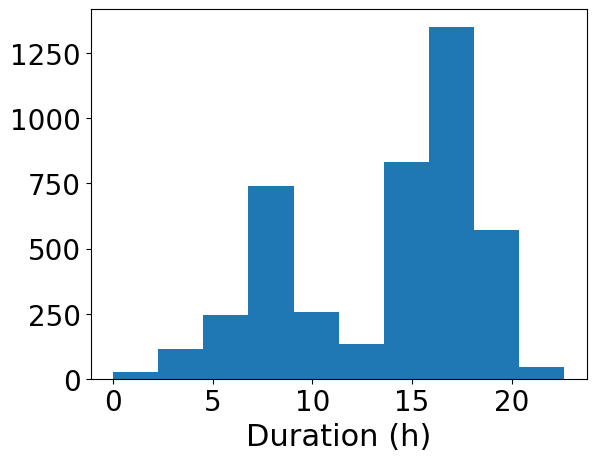

In [9]:
plt.hist(grouped_df['count']*30/3600)
plt.xlabel("Duration (h)")
plt.show()

In [ ]:
df_summary = df.groupby('animal_id').agg({'date': ['min', 'max', 'count', 'nunique']})
df_summary.columns = ['Start date', 'End date', 'Total no. of windows', 'No. of unique dates']
df_summary

,Start date,End date,Total no. of windows,No. of unique dates
animal_id,,,,
Accra,2012-04-19,2012-08-29,16852,22
Adiga,2013-08-07,2016-03-22,1006082,591
Aztec,2014-02-25,2014-10-01,230405,219
Bali,2015-01-31,2016-03-04,715600,371
Bobedi,2011-12-04,2012-06-22,110523,126
Bongwe,2012-04-11,2016-02-05,479299,272
Brian,2012-04-02,2012-05-31,24410,27
Dar,2012-04-15,2012-05-05,17939,21
Fiji,2016-03-23,2016-11-23,463086,246


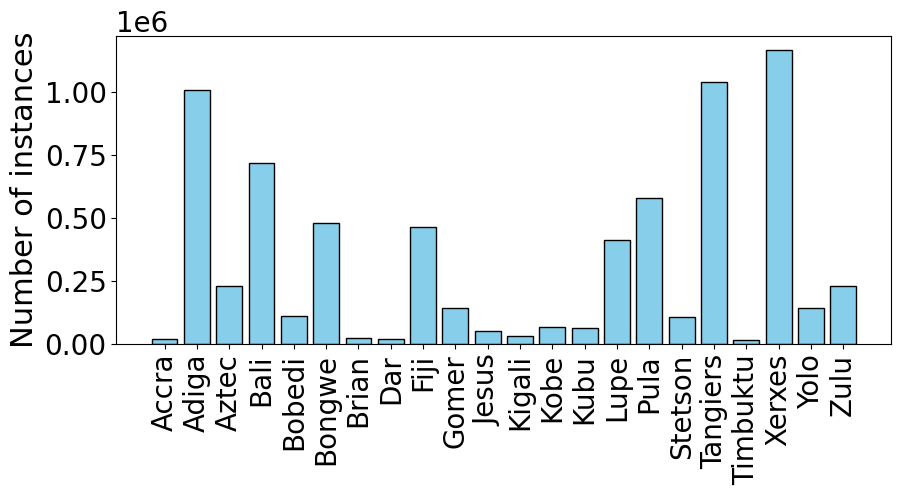

In [12]:
plt.figure(figsize = (10,4))
plt.bar(df_summary.index, df_summary['Total no. of windows'], color='skyblue', edgecolor='black')
plt.ylabel('Number of instances')
plt.xticks(rotation = 90)
plt.show()

Notice the presence of outliers for several dogs, especially Bongwe.

## 2. Outlier Detection


In [13]:
historic_data = df.copy()

lower_threshold, upper_threshold = -5, 25

for column in feats:
    # Keep only the data below this threshold
    historic_data = historic_data[(historic_data[column] <= upper_threshold) & (historic_data[column] >= lower_threshold)]

print(f"\nOriginal shape: {df.shape}")
print(f"Shape after percentile outlier removal: {historic_data.shape}")



Original shape: (7105029, 18)
Shape after percentile outlier removal: (7066277, 18)


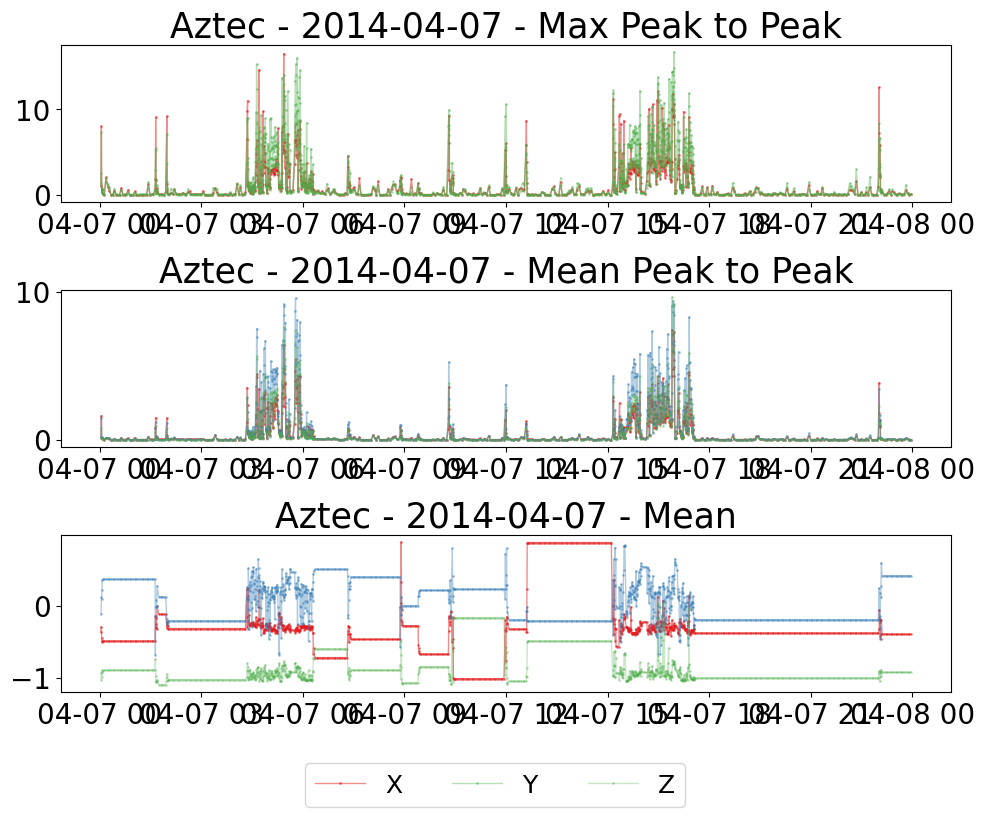

In [14]:
dogs = historic_data.animal_id.unique()
selected_dog = np.random.choice(dogs)
df_sub = historic_data[historic_data.animal_id == selected_dog]
dates = df_sub['UTC time'].dt.date.unique()
date = np.random.choice(dates)

palette = sns.color_palette("Set1", n_colors=3)

fig, axs = plt.subplots(3, 1, figsize=(10,7.5))

df_tmp = df_sub[df_sub['UTC time'].dt.date == date]
loc = AutoDateLocator()
form = AutoDateFormatter(loc)
axs[0].xaxis.set_major_locator(loc)
axs[0].xaxis.set_major_formatter(form)  
axs[0].plot(df_tmp['UTC time'], df_tmp['Max peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='X')
axs[0].plot(df_tmp['UTC time'], df_tmp['Max peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[2], label='Y')
axs[0].plot(df_tmp['UTC time'], df_tmp['Max peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Z')
axs[0].set_title(f'{selected_dog} - {str(date)} - Max Peak to Peak')
# axs[0].legend(loc='best')

axs[1].xaxis.set_major_locator(loc)
axs[1].xaxis.set_major_formatter(form)  
axs[1].plot(df_tmp['UTC time'], df_tmp['Mean peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[1].plot(df_tmp['UTC time'], df_tmp['Mean peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[1].plot(df_tmp['UTC time'], df_tmp['Mean peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[1].set_title(f'{selected_dog} - {str(date)} - Mean Peak to Peak')
# axs[1].legend(loc='best')

axs[2].xaxis.set_major_locator(loc)
axs[2].xaxis.set_major_formatter(form)  
axs[2].plot(df_tmp['UTC time'], df_tmp['Mean X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[2].plot(df_tmp['UTC time'], df_tmp['Mean Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[2].plot(df_tmp['UTC time'], df_tmp['Mean Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[2].set_title(f'{selected_dog} - {str(date)} - Mean')
# axs[2].legend(loc='best')

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
plt.tight_layout()
plt.show()

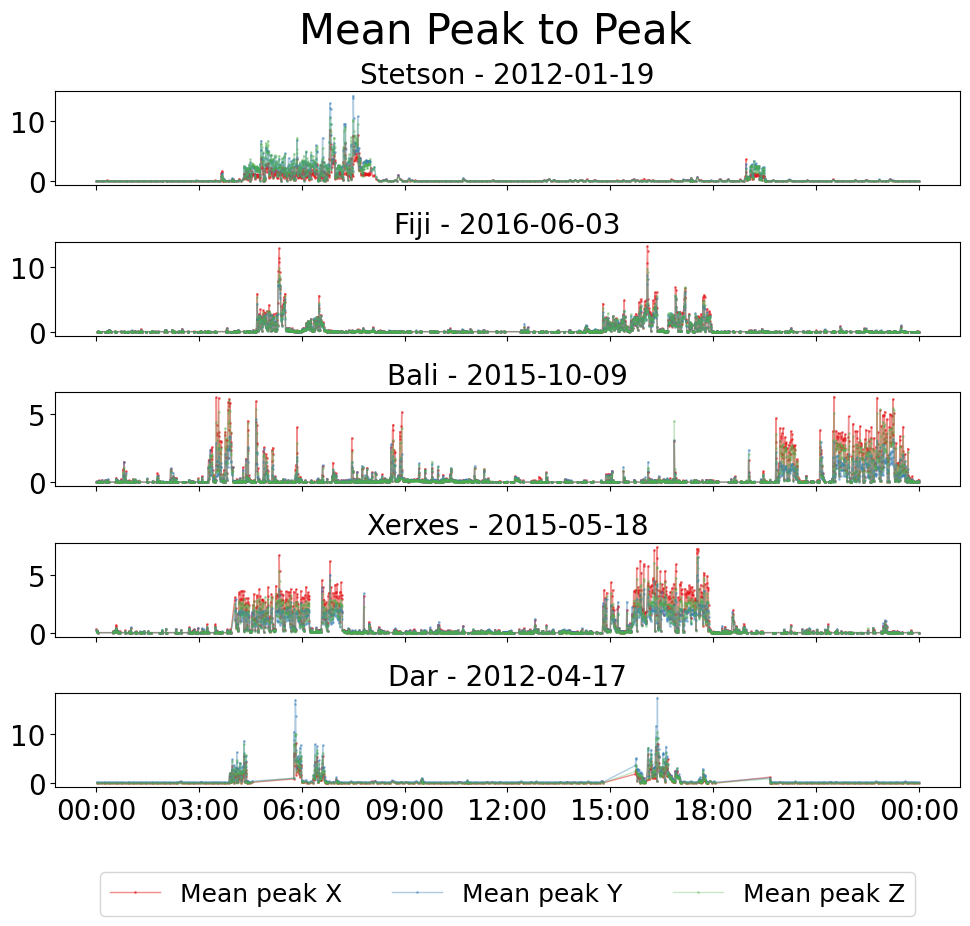

In [19]:
selected_dog_date = {'Stetson': '2012-01-19',
                     'Fiji': '2016-06-03',
                     'Bali': '2015-10-09',
                     'Xerxes': '2015-05-18',
                     'Dar': '2012-04-17'
                     }
fig, axs = plt.subplots(len(selected_dog_date), 1, figsize=(10,2*len(selected_dog_date)), sharex=True)
palette = sns.color_palette("Set1", n_colors=3)

for i, (dog, date) in enumerate(selected_dog_date.items()):
    date = datetime.strptime(date, "%Y-%m-%d").date()
    df_tmp = historic_data[(historic_data.animal_id == dog) & (historic_data['UTC time'].dt.date == date)].copy()
    
    # Replace the full datetime with a dummy date and actual time
    df_tmp['time_only'] = df_tmp['UTC time'].apply(lambda x: x.replace(year=1900, month=1, day=1))
    

    loc = AutoDateLocator()
    form = DateFormatter("%H:%M")  # or "%H:%M" if you want hours and minutes only
    axs[i].xaxis.set_major_locator(loc)
    axs[i].xaxis.set_major_formatter(form)  
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='Mean peak X')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1], label='Mean peak Y')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Mean peak Z')
    axs[i].set_title(dog + ' - ' + str(date), fontsize=20)
axs[-1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.5))
plt.suptitle(f"Mean Peak to Peak", fontsize=30)
plt.tight_layout()
plt.show()    

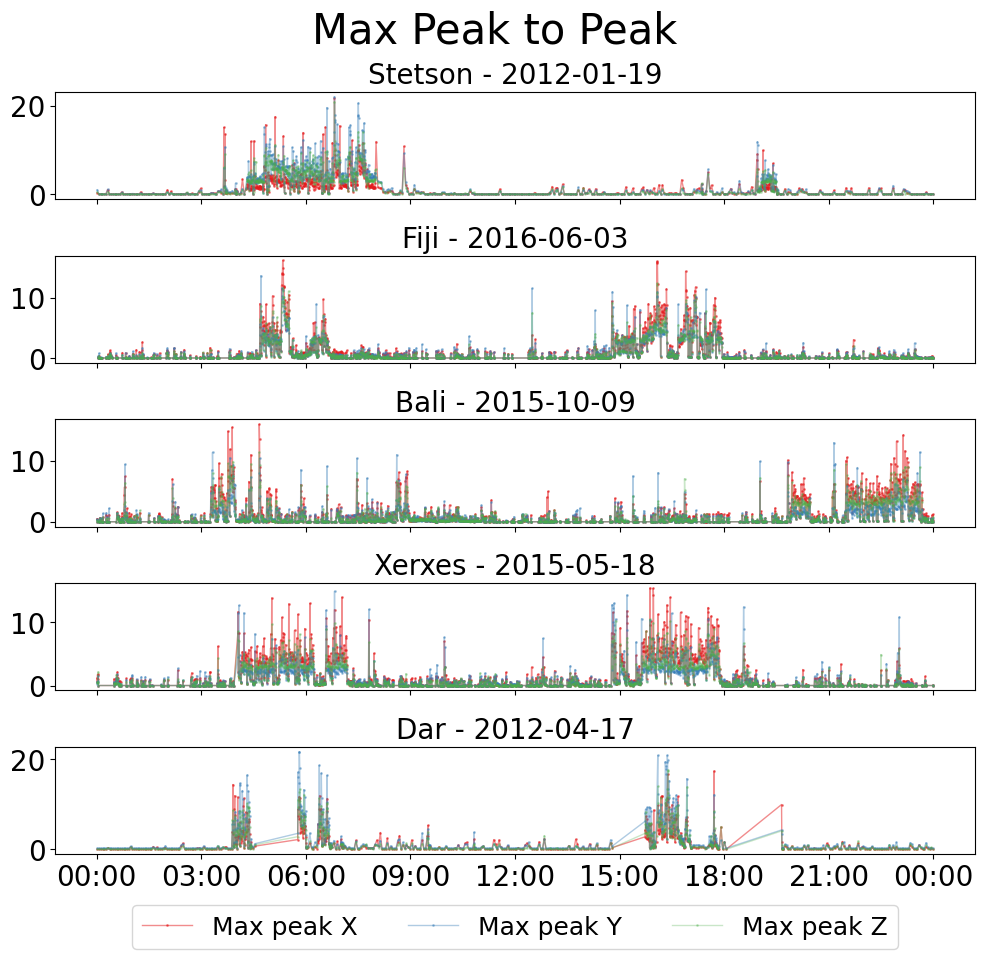

In [20]:
fig, axs = plt.subplots(len(selected_dog_date), 1, figsize=(10,2*len(selected_dog_date)), sharex=True)
palette = sns.color_palette("Set1", n_colors=3)

for i, (dog, date) in enumerate(selected_dog_date.items()):
    date = datetime.strptime(date, "%Y-%m-%d").date()
    df_tmp = historic_data[(historic_data.animal_id == dog) & (historic_data['UTC time'].dt.date == date)].copy()
    
    # Replace the full datetime with a dummy date and actual time
    df_tmp['time_only'] = df_tmp['UTC time'].apply(lambda x: x.replace(year=1900, month=1, day=1))
    

    loc = AutoDateLocator()
    form = DateFormatter("%H:%M")  # or "%H:%M" if you want hours and minutes only
    axs[i].xaxis.set_major_locator(loc)
    axs[i].xaxis.set_major_formatter(form)  
    axs[i].plot(df_tmp['time_only'], df_tmp['Max peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='Max peak X')
    axs[i].plot(df_tmp['time_only'], df_tmp['Max peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1], label='Max peak Y')
    axs[i].plot(df_tmp['time_only'], df_tmp['Max peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Max peak Z')
    axs[i].set_title(dog + ' - ' + str(date), fontsize=20)
axs[-1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.))
plt.suptitle(f"Max Peak to Peak", fontsize=30)
plt.tight_layout()
plt.show()

    

926
1781
2079
1902
700


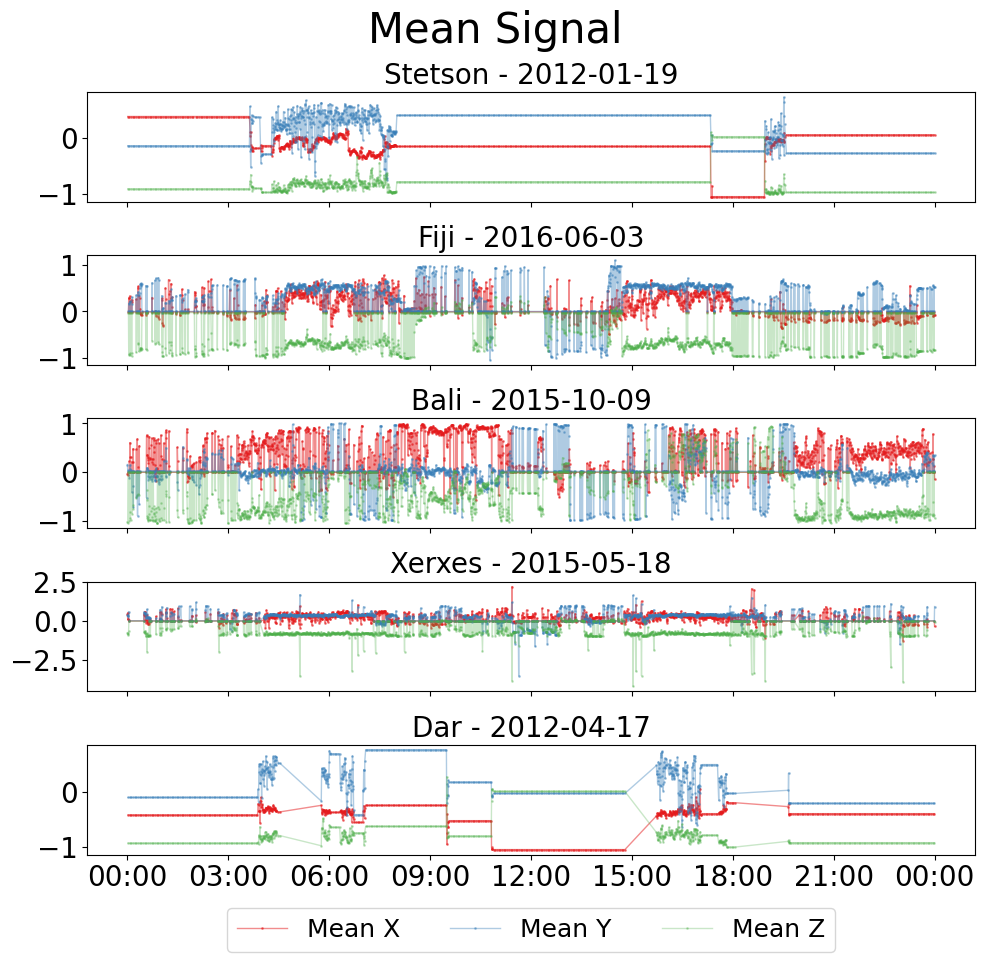

In [21]:
fig, axs = plt.subplots(len(selected_dog_date), 1, figsize=(10,2*len(selected_dog_date)), sharex=True)
palette = sns.color_palette("Set1", n_colors=3)

for i, (dog, date) in enumerate(selected_dog_date.items()):
    date = datetime.strptime(date, "%Y-%m-%d").date()
    df_tmp = historic_data[(historic_data.animal_id == dog) & (historic_data['UTC time'].dt.date == date)].copy()
    print(len(df_tmp))
    
    # Replace the full datetime with a dummy date and actual time
    df_tmp['time_only'] = df_tmp['UTC time'].apply(lambda x: x.replace(year=1900, month=1, day=1))
    
    loc = AutoDateLocator()
    form = DateFormatter("%H:%M")  # or "%H:%M" if you want hours and minutes only
    axs[i].xaxis.set_major_locator(loc)
    axs[i].xaxis.set_major_formatter(form)  
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='Mean X')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1], label='Mean Y')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Mean Z')
    axs[i].set_title(dog + ' - ' + str(date), fontsize=20)
axs[-1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.))
plt.suptitle(f"Mean Signal", fontsize=30)
plt.tight_layout()
plt.show()


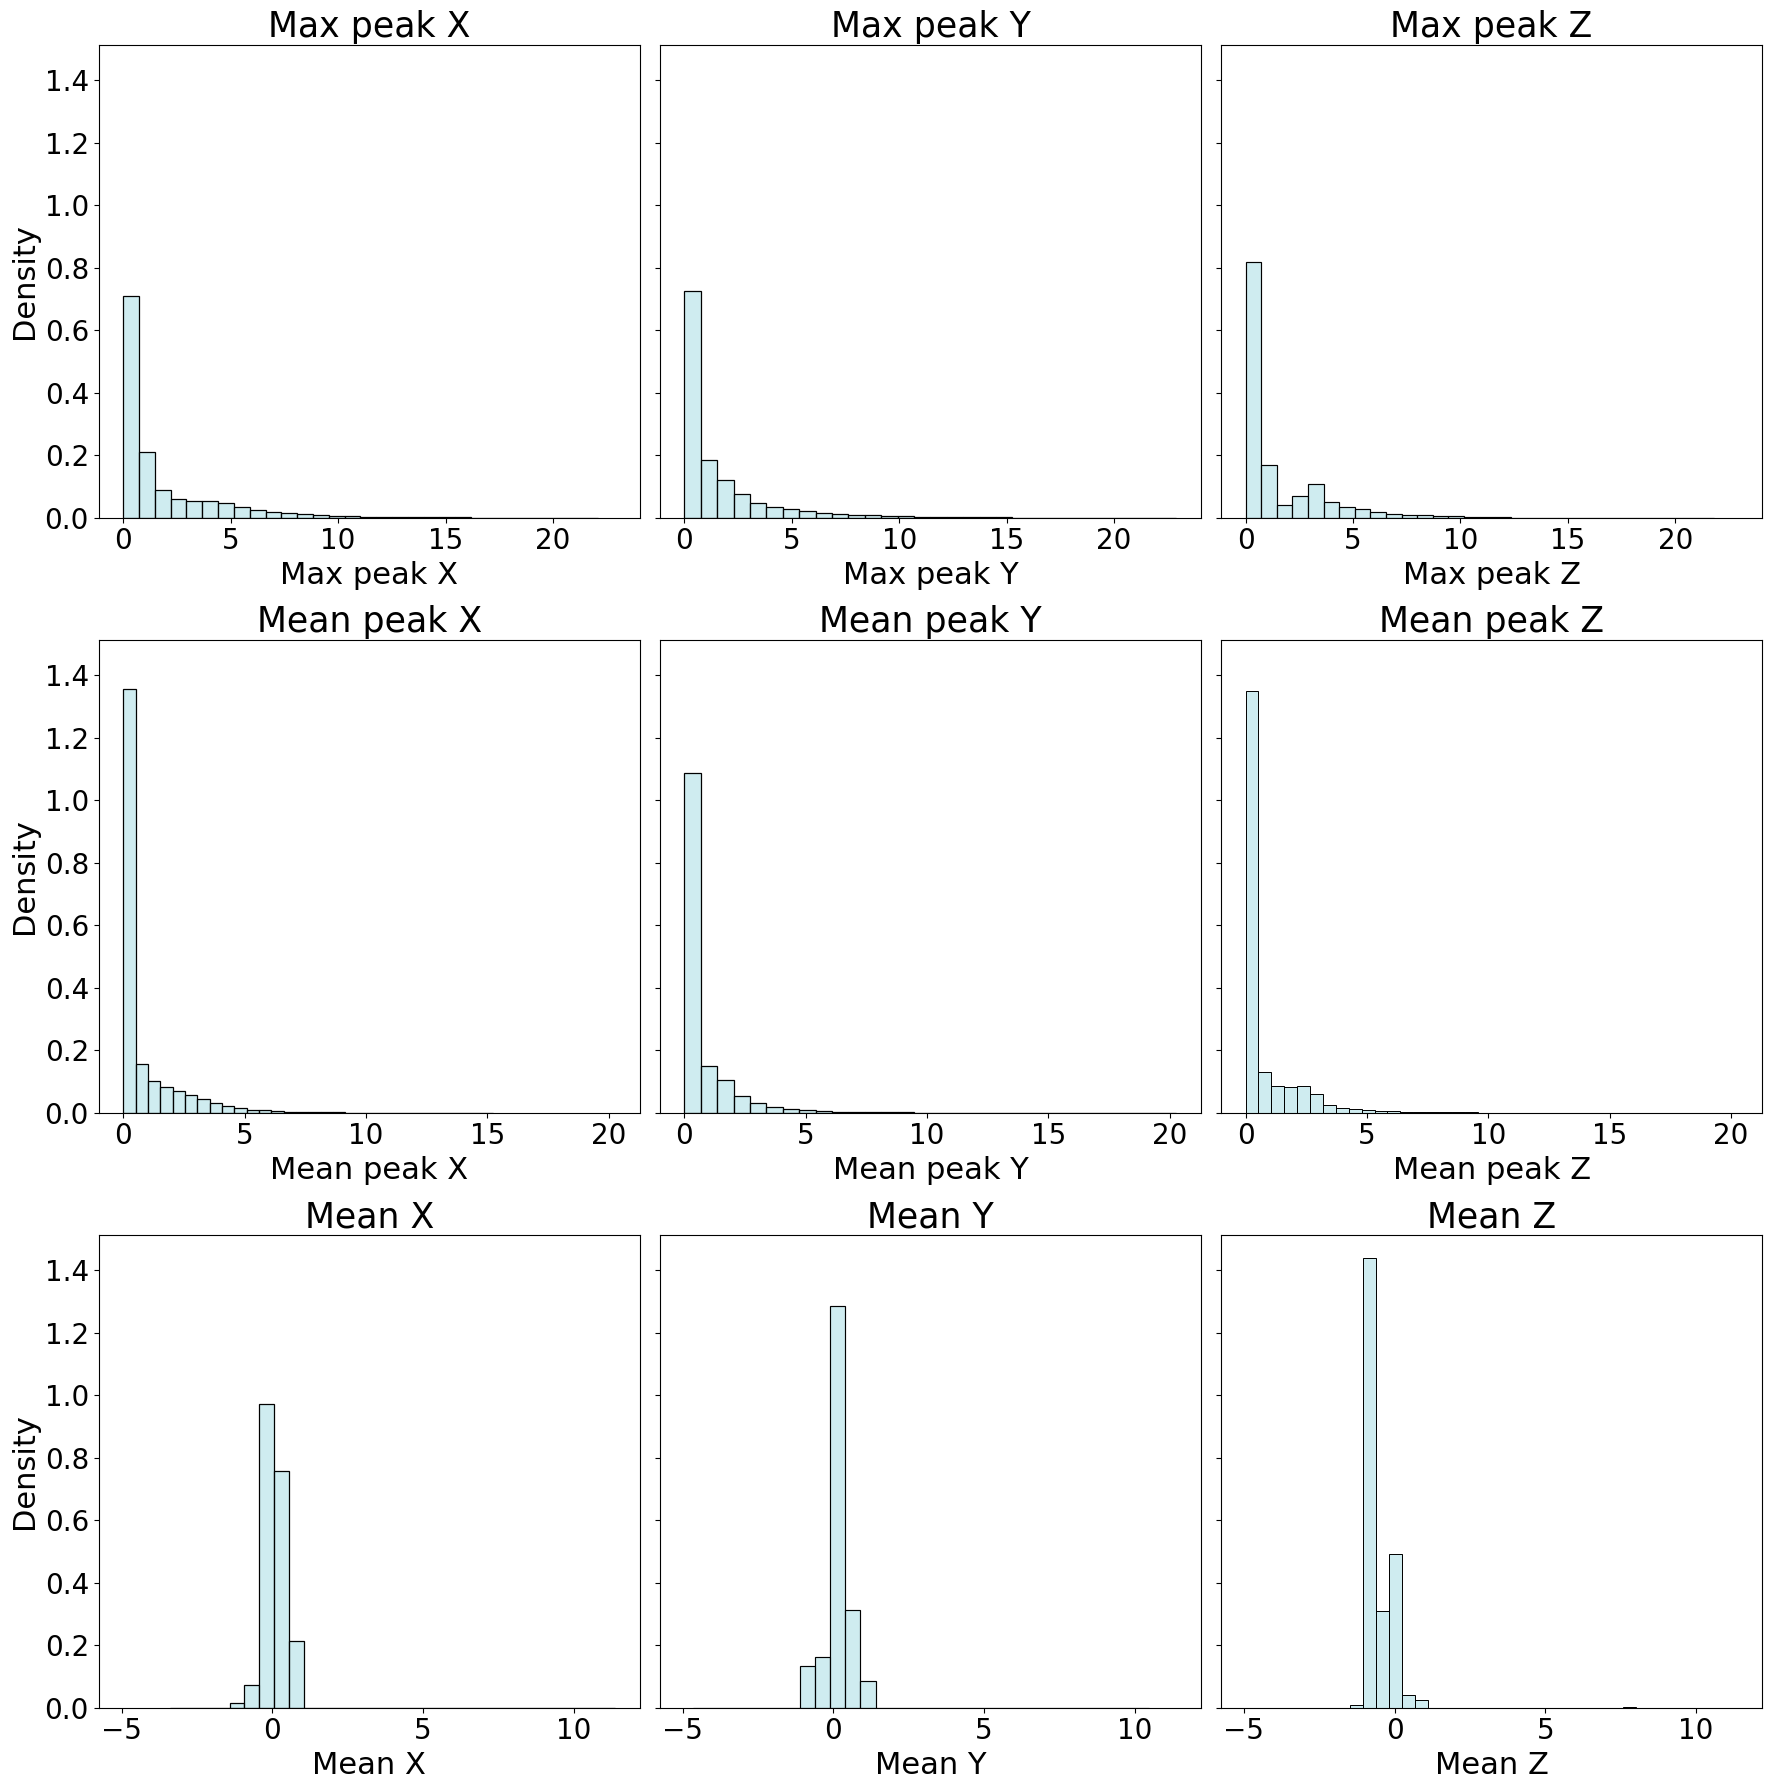

In [18]:
acc_axes = ['X', 'Y', 'Z']
feature_types = ['Max peak', 'Mean peak', 'Mean']

fig, axes = plt.subplots(len(feature_types), len(acc_axes), figsize=(6*len(acc_axes), 6*len(feature_types)), sharey=True, sharex='row')

for i, type in enumerate(feature_types):
    for j, axis in enumerate(acc_axes):

        feature = type + ' ' + axis
        ax = axes[i, j]

        sns.histplot(
                historic_data[feature],
                kde=False,
                ax=ax,
                stat='density',
                bins=30,
                color='powderblue',
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
acc_data = pd.read_csv(os.path.join(get_project_root(), 'data', "duration30", "matched_acc_data.csv"))
acc_data['acc_x'] = acc_data['acc_x'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))
acc_data['acc_y'] = acc_data['acc_y'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))
acc_data['acc_z'] = acc_data['acc_z'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))

acc_data_split = create_max_windows(acc_data=acc_data, window_duration=30.0, sampling_rate=config.SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]
split_acc_data = create_summary_data(acc_data_split, sampling_rate=config.SAMPLING_RATE)
print(f"Total {np.sum(np.isnan(acc_data_split.acc_x_ptp_max.values))} annotations have duration less than 2 seconds")

vectronics_data = split_acc_data[['acc_x_ptp_max', 'acc_y_ptp_max', 'acc_z_ptp_max',
                                  'acc_x_ptp_mean', 'acc_y_ptp_mean', 'acc_z_ptp_mean',
                                  'acc_x_mean', 'acc_y_mean', 'acc_z_mean',
                                  ]]
                                  
rename_dict = {'acc_x_ptp_max': 'Max peak X', 
               'acc_y_ptp_max': 'Max peak Y', 
               'acc_z_ptp_max': 'Max peak Z',
                'acc_x_ptp_mean': 'Mean peak X', 
                'acc_y_ptp_mean': 'Mean peak Y', 
                'acc_z_ptp_mean': 'Mean peak Z',
                'acc_x_mean': 'Mean X', 
                'acc_y_mean': 'Mean Y',  
                'acc_z_mean': 'Mean Z'}
                
vectronics_data = vectronics_data.rename(columns=rename_dict)

Total 0 annotations have duration less than 2 seconds


## 3. Scaling Methods

#### Min-Max Scaling

In [37]:
features = ['Max peak X', 'Max peak Y', 'Max peak Z',
            'Mean peak X', 'Mean peak Y', 'Mean peak Z',
            # 'Mean mag X', 'Mean mag Y', 'Mean mag Z'
            ]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Transform both datasets to fall between 0 and 1
transformed_a = vectronics_data.copy()
transformed_b = historic_data.copy()

transformed_a[features] = scaler.fit_transform(transformed_a[features])
transformed_b[features] = scaler.fit_transform(transformed_b[features])

df_transformed_a = pd.DataFrame(transformed_a, columns=features)
df_transformed_b = pd.DataFrame(transformed_b, columns=features)

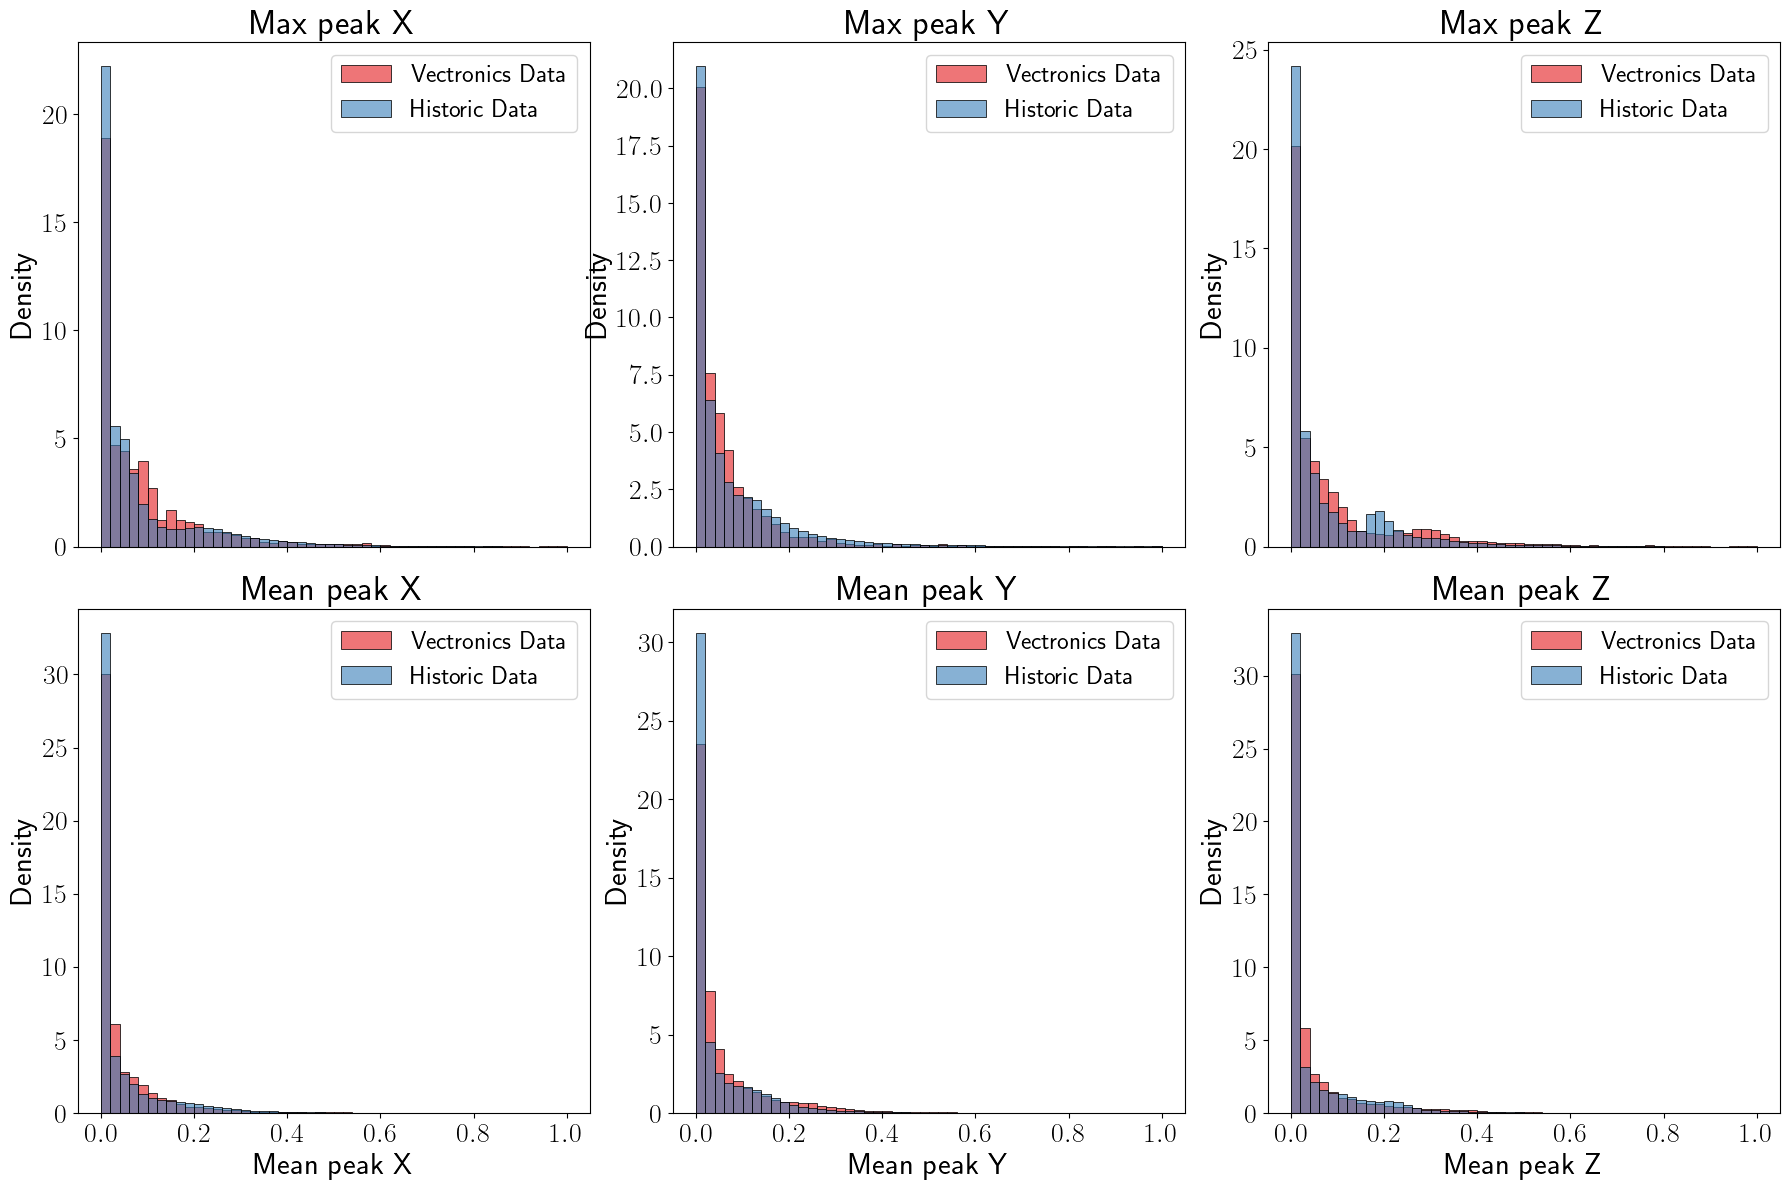

In [43]:
fig, axes = plt.subplots(len(features)//3, 3, figsize=(18, 6*(len(features)//3)), sharey=False, sharex='col')

acc_axes = ['X', 'Y', 'Z']
feature_types = ['Max peak', 'Mean peak']
palette = sns.color_palette("Set1", n_colors=2)

for i, f in enumerate(feature_types):
    for j, axis in enumerate(acc_axes):

        feature = f + ' ' + axis
        ax = axes[i, j]

        sns.histplot(
                df_transformed_a[feature],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=50,
                color=palette[0],
                alpha=0.6
            )

        sns.histplot(
                df_transformed_b[feature],
                kde=False,
                label='Historic Data',
                ax=ax,
                stat='density',
                bins=50,
                color=palette[1],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()


In [61]:
Xs = df_transformed_a[features].values
Xt = df_transformed_b[features].values

# shuffle the rows 
np.random.shuffle(Xs)
np.random.shuffle(Xt)

print(f"Number of samples in source data: {Xs.shape[0]}")
print(f"Number of samples in target data: {Xt.shape[0]}")

Number of samples in source data: 14472
Number of samples in target data: 7173771


## 4. Determin Covariate Shift

We compute the sliced Wasserstein distance and Sinkhorn divergence between the two datasets with increasing number of samples $n$ to check if the computed distance decreases as a function of $n$.

In [116]:
import numpy as np
from scipy.spatial.distance import cdist

def sinkhorn_knopp(C, epsilon=0.01, n_iters=1000, tol=1e-9):
    """
    Solve entropy-regularized optimal transport using Sinkhorn algorithm.
    Args:
        C: Cost matrix of shape (n, m)
        epsilon: Entropy regularization coefficient
        n_iters: Max number of Sinkhorn iterations
        tol: Convergence tolerance
    Returns:
        gamma: Optimal transport plan (n x m)
    """
    n, m = C.shape
    K = np.exp(-C / epsilon)

    u = np.ones(n)
    v = np.ones(m)

    # Uniform marginals
    a = np.ones(n) / n
    b = np.ones(m) / m

    for _ in range(n_iters):
        u_prev = u.copy()
        u = a / (K @ v)
        v = b / (K.T @ u)
        # Check convergence (L1 norm)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break

    gamma = np.diag(u) @ K @ np.diag(v)
    return gamma

def entropy_regularized_ot(X, Y, epsilon=0.01, n_iters=1000):
    """
    Compute entropy-regularized OT distance and transported points from X to Y.
    Args:
        X: Source dataset of shape (n, d)
        Y: Target dataset of shape (m, d)
        epsilon: Regularization parameter
    Returns:
        ot_distance: Optimal transport cost
        gamma: Optimal transport plan (n x m)
        transported_X: New position of particles in X pushed toward Y (n x d)
    """
    n, d = X.shape
    m = Y.shape[0]
    
    # Cost matrix: squared Euclidean distance
    C = cdist(X, Y, metric='sqeuclidean')  # shape (n, m)

    # Sinkhorn to get transport plan
    gamma = sinkhorn_knopp(C, epsilon, n_iters)

    # OT distance = <gamma, C>
    ot_distance = np.sum(gamma * C)

    # Transported positions: push source particles toward target barycenter
    transported_X = gamma @ Y  # shape (n, d)
    row_sums = gamma.sum(axis=1, keepdims=True)
    transported_X = transported_X / row_sums


    return ot_distance, gamma, transported_X


In [127]:
n_list = 1000 * np.arange(1, 11)

swd_list = []
for n in tqdm(n_list):
    swd = sliced_wasserstein_distance(Xs[:n,:], Xt[:n,:], num_directions=100)
    swd_list.append(swd)

dist_list = []
for n in tqdm(n_list):
    Xs_sample = Xs[:n,:]
    Ys_sample = Xt[:n,:]
    dist, _, aligned = entropy_regularized_ot(Xs_sample, Ys_sample, epsilon=0.01, n_iters=1000)
    dist_list.append(dist)

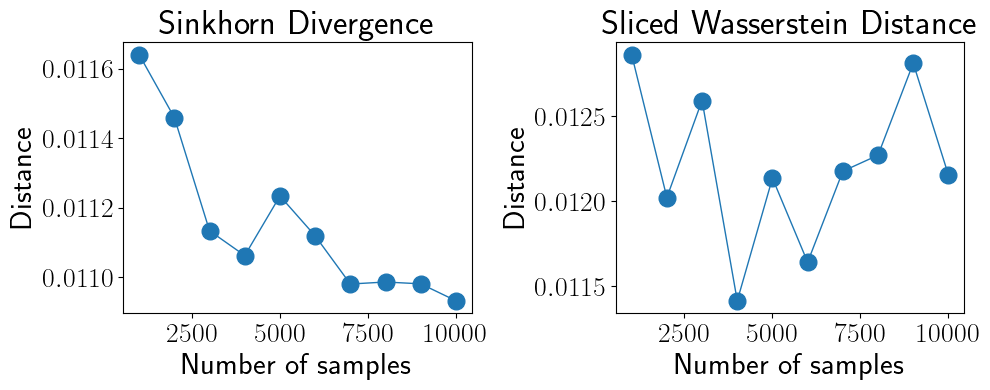

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(n_list, dist_list, marker='o')
axs[0].set_xlabel('Number of samples')
axs[0].set_ylabel('Distance')
axs[0].set_title('Sinkhorn Divergence')

axs[1].plot(n_list, swd_list, marker='o')
axs[1].set_xlabel('Number of samples')
axs[1].set_ylabel('Distance')
axs[1].set_title('Sliced Wasserstein Distance')
plt.tight_layout()
plt.show()


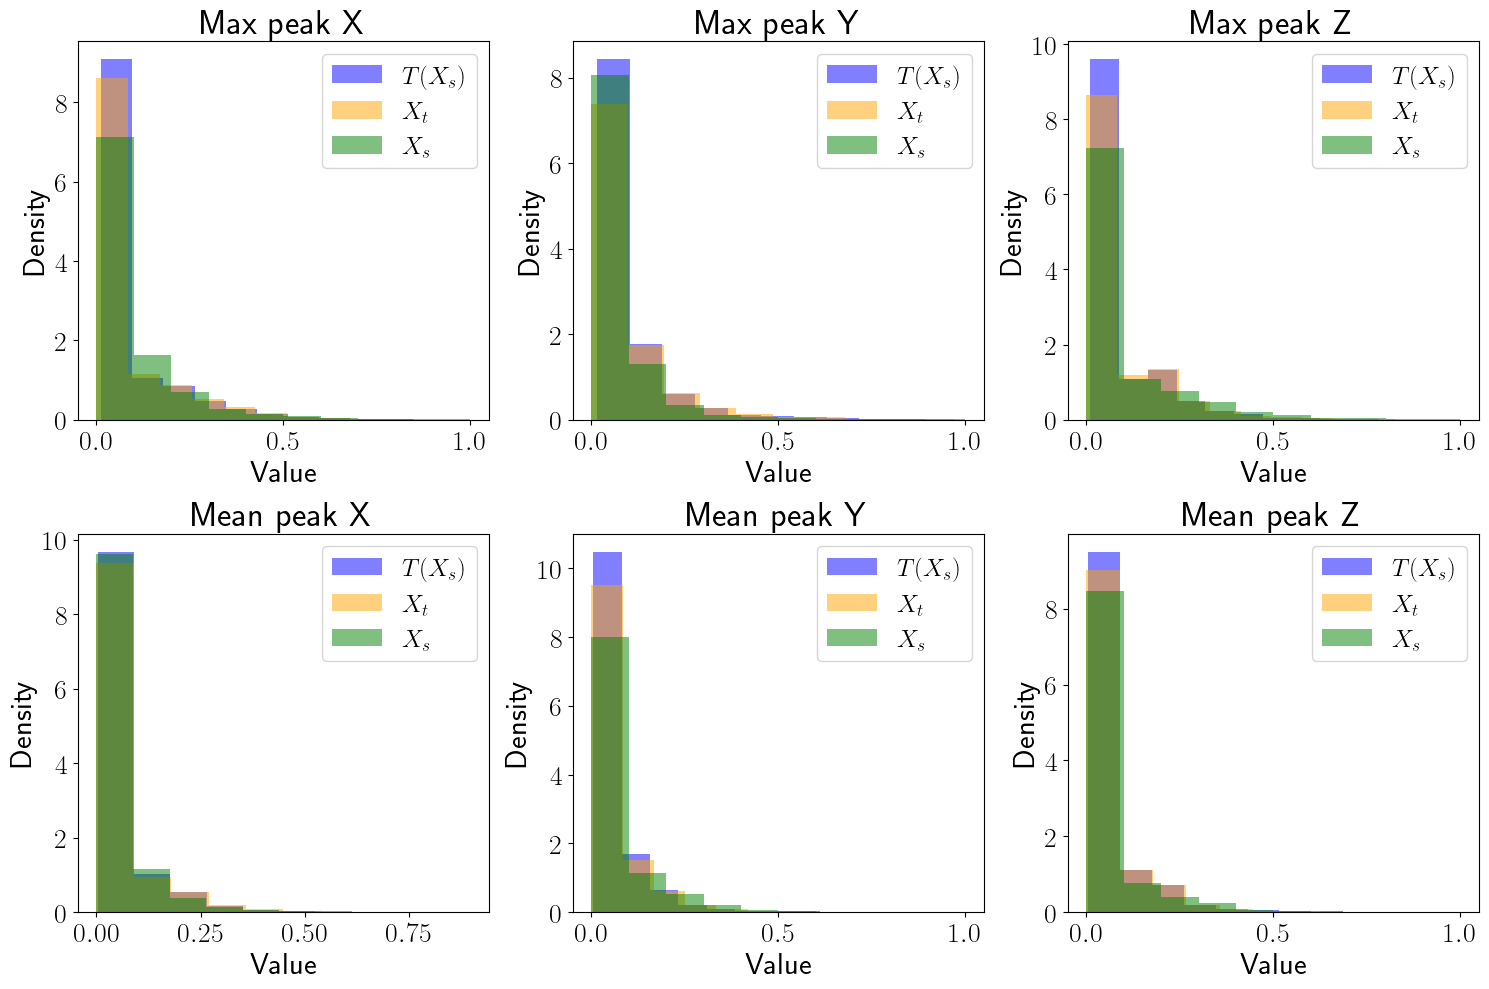

In [129]:
fig, axs = plt.subplots(len(features)//3, 3, figsize=(15, 5*len(features)//3))
n = len(aligned)
for i, ax in enumerate(axs.flat):
    ax.hist(aligned[:, i], alpha=0.5, label=r'$T(X_s)$', color='blue', density=True)
    ax.hist(Xt[:n, i], alpha=0.5, label=r'$X_t$', color='orange', density=True)
    ax.hist(Xs[:n, i], alpha=0.5, label=r'$X_s$', color='green', density=True)

    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(features[i])
    ax.legend()

plt.tight_layout()
plt.show()

In [130]:
from scipy.spatial.distance import cdist

def rbf_kernel(X, Y, sigma=1.0):
    """Compute the RBF (Gaussian) kernel between two sets of vectors."""
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (2 * sigma ** 2))

def compute_mmd(X, Y, sigma=1.0):
    """Biased estimator of MMD², guaranteed to be ≥ 0."""
    K_XX = rbf_kernel(X, X, sigma)
    K_YY = rbf_kernel(Y, Y, sigma)
    K_XY = rbf_kernel(X, Y, sigma)

    mmd2 = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd2

def mmd_test(X, Y, sigma=1.0, num_permutations=1000, seed=None):
    """Two-sample test using MMD with permutation test to get p-value."""
    rng = np.random.default_rng(seed)
    n, m = len(X), len(Y)
    Z = np.vstack([X, Y])
    observed_mmd = compute_mmd(X, Y, sigma=sigma)

    permuted_mmds = []
    for _ in range(num_permutations):
        idx = rng.permutation(n + m)
        X_perm = Z[idx[:n]]
        Y_perm = Z[idx[n:]]
        permuted_mmds.append(compute_mmd(X_perm, Y_perm, sigma=sigma))

    p_value = np.mean([mmd >= observed_mmd for mmd in permuted_mmds])
    return observed_mmd, permuted_mmds, p_value


In [131]:
def median_pairwise_distance(X, Y):
    Z = np.vstack([X, Y])
    dists = cdist(Z, Z, 'euclidean')
    return np.median(dists[np.triu_indices_from(dists, k=1)])

n, m = 2000, 2000
sigma = median_pairwise_distance(Xs[:n, :], Xt[:m, :])
stat, permuted_stat, pval = mmd_test(X=Xs[:n, :], Y=Xt[:m, :], sigma=sigma, num_permutations=1000, seed=42)

print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H0).")

MMD^2 statistic: 0.0122
P-value: 0.0000 - The two distributions are significantly different (reject H0).
